In [1]:
import os
from utilities import (extract_image_from_pdf, extract_xml_from_digital_pdf,
                       create_directory, read_directory_files, get_subdirectories,
                       get_string_xmltree, get_xmltree, get_specific_tags, get_page_texts_ordered,
                       get_page_text_element_attrib, get_ngram
                      )
from xml_document_info import (get_xml_info)
from vertical_spacing_main import main, draw_bbox_coord
from box_horizontal_operations import (merge_horizontal_blocks)
from box_vertical_operations import (merge_vertical_blocks)

import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import copy


## Draw the boxes on document pages

In [2]:
def draw_box(filepath, desired_width, desired_height, df, color="green", save=False):
    image  = Image.open(filepath)
    image  = image.resize((desired_width, desired_height))
    draw   = ImageDraw.Draw(image)
    
    for index, row in df.iterrows():
        left   = int(row['text_left'])
        right  = int(row['text_width'] + left)
        top    = int(row['text_top'])
        bottom = int(row["text_height"] + top)
        
        draw.rectangle(((left, top), (right,bottom)), outline=color)
    save_filepath = os.path.join(os.path.dirname(filepath), 'processed_' + os.path.basename(filepath))
    if save:
        image.save(save_filepath)
    
    return image

def show_df(df):
    return df.head(df.shape[0])

## start of program

In [5]:
base_dir   = '/home/naresh/Tesseract/document-structure/data'
input_dir  = os.path.join(base_dir, 'input')
output_dir = os.path.join(base_dir, 'output')
filename   = 'Madras_HC_02.pdf'


In [6]:
pdf_filepath   = os.path.join(input_dir, filename)
working_dir    = os.path.join(output_dir, os.path.splitext(filename)[0])

ret            = create_directory(working_dir)

pdf_image_dir  = extract_image_from_pdf(pdf_filepath, working_dir)
pdf_xml_dir    = extract_xml_from_digital_pdf(pdf_filepath, working_dir)

xml_files      = read_directory_files(pdf_xml_dir, pattern='*.xml')
# print(xml_files, "\n\n")
image_files    = read_directory_files(pdf_image_dir, pattern='*-*.jpg')
# print(image_files)
print("Extracted xml & images of file: %s" % (filename))

Extracted xml & images of file: Madras_HC_02.pdf


In [7]:
xml_dfs, page_width, page_height = get_xml_info(xml_files[0])

Total number of pages (4) in file (Madras_HC_02.xml)


In [8]:
document_configs = {
    'HORI_BLOCK_WDTH_DIFF_PERC': 0.85,
    'SUPERSCRIPT_HEIGHT_DIFFERENCE': 7.0,
    'HORI_SPACE_TOO_CLOSE': 10.0,
    
    'VERTICAL_SPACE_TOO_CLOSE': 5.0,
    'AVERAGE_VERTICAL_SPACE': 12.0,
    'LEFT_OR_RIGHT_ALIGNMENT_MARGIN': 20.0
}

In [9]:
file_index=0
img_filepath   = image_files[file_index]
df             = xml_dfs[file_index]


# vertical spacings

In [10]:
dataframe = main(image_files,xml_dfs, page_width, page_height,document_configs)

#####draw bounding boxes
draw_bbox_coord(image_files, dataframe)

In [9]:
dataframe

,index,xml_index,text_top,text_left,text_width,text_height,text,font_size,font_family,font_color,children,page_no,page_width,page_height,spacings,paragraph,para_no
0,0,0,139,447,9,20,1,16,Times,#000000,None,1,892,1262,139,"[139, 139, 750, 571]",1
1,1,1,181,170,561,21,BEFORE THE MADURAI BENCH OF MADRAS HIGH COURT,16,Times,#000000,None,1,892,1262,22,"[139, 139, 750, 571]",1
2,2,2,223,357,187,21,DATED: 26.02.2020,16,Times,#000000,None,1,892,1262,21,"[139, 139, 750, 571]",1
3,3,3,276,411,80,21,CORAM:,16,Times,#000000,None,1,892,1262,32,"[139, 139, 750, 571]",1
4,4,4,318,153,597,21,THE HONOURABLE MR.JUSTICE A.D.JAGADISH CHANDIRA,16,Times,#000000,None,1,892,1262,21,"[139, 139, 750, 571]",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,1,1,181,462,301,21,"A.D.JAGADISH CHANDIRA, J.,",16,Times,#000000,None,4,892,1262,22,"[447, 139, 763, 244]",14
65,2,2,223,730,32,21,gns,16,Times,#000000,None,4,892,1262,21,"[447, 139, 763, 244]",14
66,3,3,603,511,252,21,Cont.P.(MD)No.123 of 2020,16,Times,#000000,None,4,892,1262,359,"[511, 603, 763, 1087]",15
67,4,4,1066,659,104,21,26.02.2020,16,Times,#000000,None,4,892,1262,442,"[511, 603, 763, 1087]",15


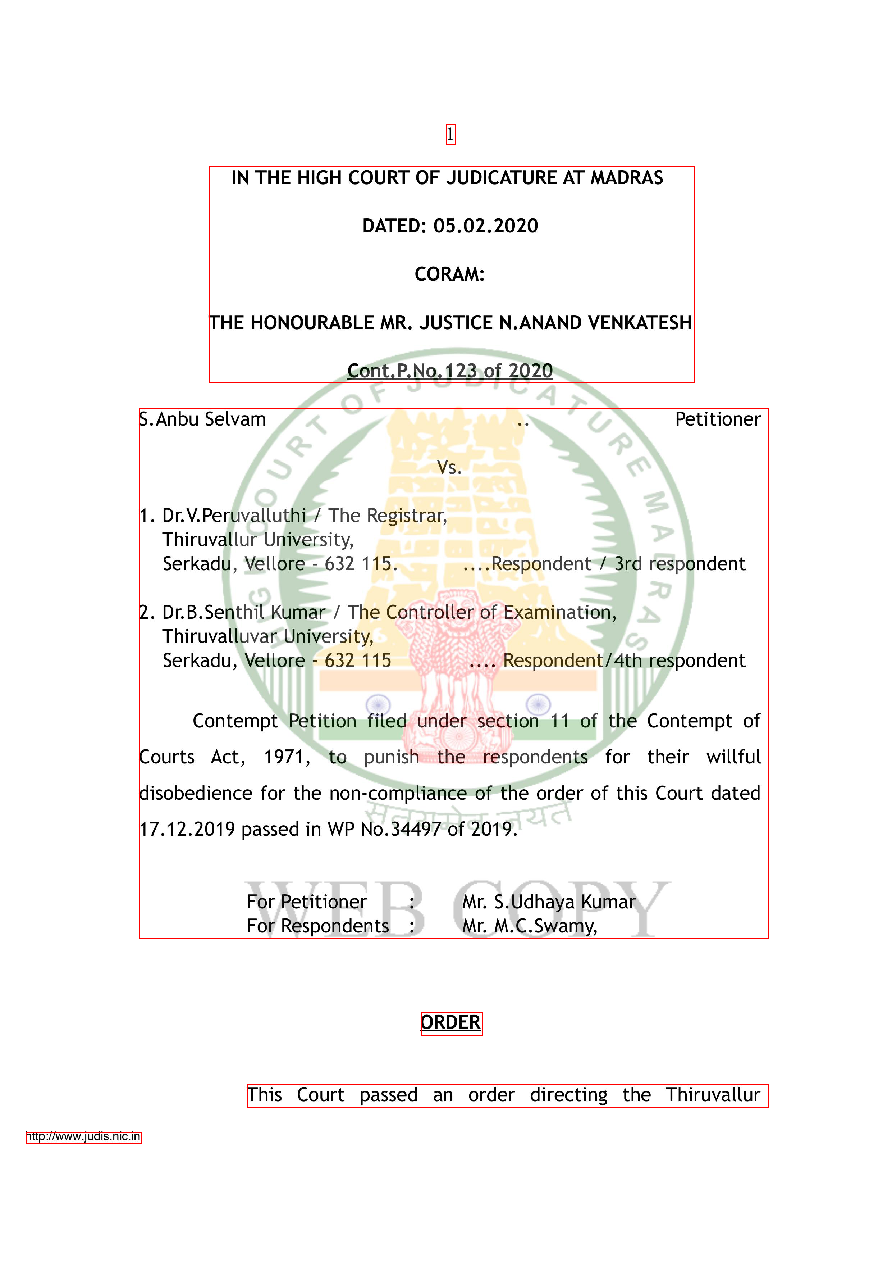

In [41]:
in_df   = df.loc[:]

h_df    = merge_horizontal_blocks(in_df, document_configs, debug=False)
v_df    = merge_vertical_blocks(h_df, document_configs, debug=False)

draw_box(img_filepath, page_width, page_height, v_df, color='red')
# show_df(h_df)


In [42]:
show_df(h_df)


,xml_index,text_top,text_left,text_width,text_height,text,font_size,font_family,font_color,children
0,0,124,446,9,20,1,18,BAAAAA+TimesNewRomanPSMT,#000000,None
1,1,166,232,439,23,IN THE HIGH COURT OF JUDICATURE AT MADRAS,19,CAAAAA+TrebuchetMS,#000000,None
2,2,215,363,176,23,DATED: 05.02.2020,19,CAAAAA+TrebuchetMS,#000000,None
3,3,263,415,71,23,CORAM:,19,CAAAAA+TrebuchetMS,#000000,None
4,4,311,209,485,23,THE HONOURABLE MR. JUSTICE N.ANAND VENKATESH,19,CAAAAA+TrebuchetMS,#000000,None
5,5,359,348,206,23,Cont.P.No.123 of 2020,19,CAAAAA+TrebuchetMS,#000000,None
6,6,408,139,623,23,S.Anbu Selvam .. Petitioner,19,DAAAAA+TrebuchetMS,#000000,"{""xml_index"":{""6"":6,""7"":7,""8"":8},""text_top"":{""..."
7,9,456,438,27,23,Vs.,19,DAAAAA+TrebuchetMS,#000000,None
8,10,504,139,310,23,"1. Dr.V.Peruvalluthi / The Registrar,",19,DAAAAA+TrebuchetMS,#000000,None
9,11,529,139,217,23,"Thiruvallur University,",19,DAAAAA+TrebuchetMS,#000000,None


In [32]:

    
def process_page_blocks(page_df, configs, debug=False):
    cols      = page_df.columns.values.tolist()
    df        = pd.DataFrame(columns=cols)
    
    block_index = 0
    for index, row in page_df.iterrows():
        if row['children'] == None:
            df.loc[block_index] = page_df.iloc[index]
            block_index += 1
        else:
            dfs = process_block(page_df.iloc[index]['children'])
            block_index += 1
    return df

In [33]:
def process_block(children):
    in_df      = pd.read_json(children)
    df         = in_df.copy(deep=True)
    df         = in_df.reset_index()
    
#     c_df = pd.read_json(block_df['children'])
#     c_df.reset_index(drop=True)
    return in_df

In [34]:
p_df = process_page_blocks(v_df, document_configs)

In [35]:
c_df = process_block(v_df.loc[0]['children'])
show_df(c_df)

,children,font_color,font_family,font_size,text,text_height,text_left,text_top,text_width,xml_index
0,None,#000000,BookAntiqua,27,RAJYA SABHA,27,381,33,203,0
1,"{""xml_index"":{""1"":1,""2"":2,""3"":3},""text_top"":{""...",#000000,BookAntiqua,27,VALEDICTORY REMARKS – 241 st Session,27,208,65,549,1
2,None,#000000,BookAntiqua,27,( 16.12.2016 ),27,403,98,160,4
